## System Description
1. We have a set of COFs from a database. Each COF is characterized by a feature vector $$x_{COF} \in X \subset R^d$$ were d=14.


2. We have **two different types** of simulations to calculate **the same material property $S_{Xe/Kr}$**. Therefore, we have a Single-Task/Objective (find the material with the optimal selevtivity), Multi-Fidelity problem. 
    1. low-fidelity  = Henry coefficient calculation - MC integration 
    2. high-fidelity = GCMC mixture simulation - 80:20 (Kr:Xe) at 298 K and 1.0 bar 


3. We will initialize the system with a few COFs at **both** fidelities in order to initialize the Covariance Matrix.
    1. The fist COF will be the one closest to the center of the normalized feature space
    2. The rest will be chosen to maximize diversity of the training set


4. Each surrogate model will **only train on data acquired at its level of fidelity** (Heterotopic data). $$X_{lf} \neq X_{hf} \subset X$$
    1. We could use the augmented EI acquisition function from [here](https://link.springer.com/content/pdf/10.1007/s00158-005-0587-0.pdf)
    2. We could use a naive implementation of the [misoKG](https://papers.nips.cc/paper/2017/file/df1f1d20ee86704251795841e6a9405a-Paper.pdf) acquisition function
    3. Helpful [tutorial](https://botorch.org/tutorials/discrete_multi_fidelity_bo)


5. **kernel model**: 
    1.  We need a Gaussian Process (GP) that will give a *correlated output for each fidelity* i.e. we need a vector-valued kernel
    2. Given the *cost aware* acquisition function, we anticipate the number of training points at each fidelity *will not* be equal (asymmetric scenario) $$n_{lf} > n_{hf}$$

### TODO:

- add random search to single/high-fidelity plot 
- draw COF structure that is the top one
- have cell in notebook that prints cost of all henry calcs
- viz acquired set in 2D projection of feature space. two different markers, one for low one for high fidelity. at say 4 different points along the BO search
- why this acquisition function? => simple, easy to compute. cost-aware.
- put timer in code that reports the time for the BO search (if this takes long, not good). should report that.
- viz optimal acquisition function value as time goes on


notes:

Normally we run sel on all and then do gcmc in the top, what if we selected 20 at random? 
Budget of num COFs (high-fidelity) or devide num selections into batches with updated list of 

x-asis = num of cofs evaluated
y-axis = pick x at random and screen those

more domain analysis:
- plot params and see if they cluster (something like the PCA in [this](https://doi.org/10.1039/D1ME00093D) paper)

In [1]:
import torch
import gpytorch
from botorch.models import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from scipy.stats import norm
import math 
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

# config plot settings
plt.rcParams["font.size"] = 16

In [2]:
###
#  Load Data
###
f = h5py.File("targets_and_normalized_features.jld2", "r")
# feature matrix
X = torch.from_numpy(np.transpose(f["X"][:]))
# simulation data
y = [torch.from_numpy(np.transpose(f["henry_y"][:])), 
     torch.from_numpy(np.transpose(f["gcmc_y"][:]))]
# associated simulation costs
cost = [torch.from_numpy(np.transpose(f["henry_total_elapsed_time"][:])), 
        torch.from_numpy(np.transpose(f["gcmc_elapsed_time"][:]))]

# total number of COFs in data set
nb_COFs = X.shape[0] 

print("raw data - \n\tX:", X.shape)
for f in range(2):
    print("\tfidelity:", f)
    print("\t\ty:", y[f].shape)
    print("\t\tcost: ", cost[f].shape)
    
    
print("\nEnsure features are normalized - ")
print("max:\n", torch.max(X, 0).values)
print("min:\n", torch.min(X, 0).values)

raw data - 
	X: torch.Size([608, 14])
	fidelity: 0
		y: torch.Size([608])
		cost:  torch.Size([608])
	fidelity: 1
		y: torch.Size([608])
		cost:  torch.Size([608])

Ensure features are normalized - 
max:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)
min:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)


In [3]:
print("average high-fidelity cost:", torch.mean(cost[1]).item(), "[min]")
print("average low-fidelity cost: ", torch.mean(cost[0]).item(), "[min]")
print("average cost ratio:\t   ", torch.mean(cost[1] / cost[0]).item())

average high-fidelity cost: 230.0783918372241 [min]
average low-fidelity cost:  16.57287046034216 [min]
average cost ratio:	    13.444745568580501


In [4]:
total_lf_cost = sum(cost[0])
total_lf_cost

tensor(10076.3052, dtype=torch.float64)

In [5]:
total_hf_cost = sum(cost[1])
total_hf_cost

tensor(139887.6622, dtype=torch.float64)

## Helper Functions

#### Construct Initial Inputs

In [6]:
# find COF closest to the center of feature space
def get_initializing_COF(X):
    # center of feature space
    feature_center = np.ones(X.shape[1]) * 0.5
    # max possible distance between normalized features
    return np.argmin(np.linalg.norm(X - feature_center, axis=1))

def diverse_set(X, train_size):
    # initialize with one random point; pick others in a max diverse fashion
    ids_train = [get_initializing_COF(X)]
    # select remaining training points
    for j in range(train_size - 1):
        # for each point in data set, compute its min dist to training set
        dist_to_train_set = np.linalg.norm(X - X[ids_train, None, :], axis=2)
        assert np.shape(dist_to_train_set) == (len(ids_train), nb_COFs)
        min_dist_to_a_training_pt = np.min(dist_to_train_set, axis=0)
        assert np.size(min_dist_to_a_training_pt) == nb_COFs
        
        # acquire point with max(min distance to train set) i.e. Furthest from train set
        ids_train.append(np.argmax(min_dist_to_a_training_pt))
    assert np.size(np.unique(ids_train)) == train_size # must be unique
    return np.array(ids_train)

In [7]:
# construct feature matrix of acquired points
def build_X_train(ids_acquired, fidelity_acquired):
    return torch.cat((X[ids_acquired, :], fidelity_acquired.unsqueeze(dim=-1)), dim=1)

# construct output vector for acquired points
def build_y_train(ids_acquired, fidelity_acquired):
    train_y = torch.tensor((), dtype=torch.float64).new_zeros((ids_acquired.shape[0], 1))
    for i, fid in enumerate(fidelity_acquired):
        train_y[i][0] = y[fid][ids_acquired[i]]
    return train_y

# construct vector to track accumulated cost of acquired points
def build_cost(ids_acquired, fidelity_acquired):
    costs_acquired = torch.tensor((), dtype=torch.float64).new_zeros((ids_acquired.shape[0], 1))
    for i, fid in enumerate(fidelity_acquired):
        costs_acquired[i][0] = cost[fid][ids_acquired[i]]
    return costs_acquired

In [8]:
def test_initializing_functions(X, y):
    # number of COFs to initialize with at each fidelity
    nb_COFs_initialization = 3
    # select COFs to train initial GP
    initializing_COFs = torch.from_numpy(np.array([1, 3, 4]))
    # track COFs acquired
    ids_acquired = torch.from_numpy(np.array([1, 3, 4]))
    print("Test -\n\tids acquired", ids_acquired)
    # track the fidelity at which COFs are acquired
    fidelity_acquired = torch.from_numpy(np.array([1, 0, 0]))
    print("\tfidelity acquired", fidelity_acquired)
    # construct training sets
    X_train = build_X_train(ids_acquired, fidelity_acquired)
    y_train = build_y_train(ids_acquired, fidelity_acquired)
    # Test that the constructor functions are working properly
    assert np.allclose(X[1, :], X_train[0, :14])
    assert X_train[0, 14] == 1
    assert X_train[1, 14] == 0
    assert y_train[0] == y[0]
    return

#### Surrogate Model

In [9]:
def train_surrogate_model(X_train, y_train):
    model = SingleTaskMultiFidelityGP(
        X_train, 
        y_train, 
        outcome_transform=Standardize(m=1), # m is the output dimension
        data_fidelity=X_train.shape[1] - 1
    )   
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return mll, model

#### Acquisition Function

In [10]:
# calculate posterior mean and variance
def mu_sigma(model, X, fidelity):
    f = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity
    f_posterior = model.posterior(X_f)
    return f_posterior.mean.squeeze().detach().numpy(), f_posterior.variance.squeeze().detach().numpy()

# get the current "effective best solution" 
def get_y_max(ids_acquired, fidelity_acquired, desired_fidelity):
    y_max = torch.tensor((), dtype=torch.float64).new_zeros(1)
    for i, fid in enumerate(fidelity_acquired):
        if (fid == desired_fidelity) & (y[fid][ids_acquired[i]] > y_max):
            y_max = y[fid][ids_acquired[i]]
    return y_max.item()

In [11]:
###
#  Multi-fideltiy correlation 
###
def multi_fidelity_correlation(model, X, fidelity, ids_acquired, fidelity_acquired):
    # get covariance matrix of acquired data points
    K = model.covar_module(X_train).evaluate() 
    K_inv = torch.inverse(K) # take the inverse

    # get posterior for fidelity f
    f   = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity
    sigma_f = torch.flatten(model.posterior(X_f).variance)

    # get posterior for high-fidelity
    hf = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) 
    X_hf = torch.cat((X, hf), dim=1) # last col is associated fidelity
    sigma_hf = torch.flatten(model.posterior(X_hf).variance)

    # Compute the covariance between X_hf and X_f, using covariance kernel
    sigma_prior = model.covar_module.forward(X_hf, X_f, diag=True) # want diag

    # Compute the covariance between X_f and X_train 
    # rows are [k(x,s), (x_1, s_1), ..., k((x, s), (x_N, s_N))]
    cov_f_and_data = model.covar_module.forward(X_f, X_train).evaluate()

    # Compute the covariance between X_hf and X_train
    # rows are [k(x,s'), (x_1, s_1), ..., k((x, s'), (x_N, s_N))]
    cov_hf_and_data = model.covar_module.forward(X_hf, X_train).evaluate()

    # perform matrix multiplication
    sigma_reduction = torch.matmul(torch.matmul(cov_f_and_data, K_inv), 
                       torch.t(cov_hf_and_data)).diag()
    # calculate covariance
    posterior_cov = sigma_prior - sigma_reduction
    # calculate the correlation
    corr = posterior_cov / (torch.sqrt(sigma_f) * torch.sqrt(sigma_hf))
    return corr

###
#  Cost ratio
###
def cost_ratio(fidelity, fidelity_acquired, costs_acquired):
    avg_cost_f  = torch.mean(costs_acquired[fidelity_acquired == fidelity]).item()
    avg_cost_hf = torch.mean(costs_acquired[fidelity_acquired == 1]).item()
    return avg_cost_hf / avg_cost_f

###
#  Expected Imrovement function, only uses hf
###
def EI_hf(model, X, ids_acquired, fidelity_acquired):
    hf_mu, hf_sigma = mu_sigma(model, X, 1)
    y_max = get_y_max(ids_acquired, fidelity_acquired, 1)
    
    z = (hf_mu - y_max) / hf_sigma
    explore_term = hf_sigma * norm.pdf(z)
    exploit_term = (hf_mu - y_max) * norm.cdf(z)
    ei = explore_term + exploit_term
    return np.maximum(ei, np.zeros(nb_COFs))

###
#  Acquisition function
###
def acquisition(model, X, fidelity, ids_acquired, fidelity_acquired, costs_acquired):
    # expected improvement for high-fidelity
    ei = EI_hf(model, X, ids_acquired, fidelity_acquired) 
    
    # augmenting functions
    a1 = multi_fidelity_correlation(model, X, fidelity, ids_acquired, fidelity_acquired)
    a2 = 1.0 # no systematic random error noise 
    a3 = cost_ratio(fidelity, fidelity_acquired, costs_acquired)

    acquisition_values = torch.from_numpy(ei) * a1 * a2 * a3
    return acquisition_values, acquisition_values.argsort(descending=True) # sort in descending order

# Run MFBO

In [12]:
def construct_initial_inputs(X, y, nb_COFs_initialization):
    initializing_COFs = torch.from_numpy(diverse_set(X, nb_COFs_initialization))
    
    ids_acquired = torch.cat((initializing_COFs, initializing_COFs))
    
    fidelity_acquired = torch.cat((torch.ones((nb_COFs_initialization), dtype=int), 
                               torch.zeros((nb_COFs_initialization), dtype=int)))
    
    costs_acquired = build_cost(ids_acquired, fidelity_acquired)
    return ids_acquired, fidelity_acquired, costs_acquired

In [13]:
###
#  construct initial inputs
###
nb_COFs_initialization = 3 # at each fidelity, number of COFs to initialize with
nb_iterations = 100        # BO budget, includes initializing COFs

ids_acquired, fidelity_acquired, costs_acquired = construct_initial_inputs(X, y, nb_COFs_initialization)

X_train = build_X_train(ids_acquired, fidelity_acquired)
y_train = build_y_train(ids_acquired, fidelity_acquired)

print("Initialization - \n")
print("\tid acquired = ", ids_acquired.squeeze().detach().numpy())
print("\tfidelity acquired = ", fidelity_acquired.squeeze().detach().numpy())
print("\tcosts acquired = ", costs_acquired.squeeze().detach().numpy(), " [min]")

print("\tTraining data:\n")
print("\t\t X train shape = ", X_train.shape)
print("\t\t y train shape = ", y_train.shape)
print("\t\t training feature vector = \n", X_train[0])

Initialization - 

	id acquired =  [ 25 494 523  25 494 523]
	fidelity acquired =  [1 1 1 0 0 0]
	costs acquired =  [399.7576661  171.99848711 280.45236813  33.25071268  33.2388743
   6.12068812]  [min]
	Training data:

		 X train shape =  torch.Size([6, 15])
		 y train shape =  torch.Size([6, 1])
		 training feature vector = 
 tensor([0.1500, 0.4533, 0.1088, 0.5523, 0.4387, 0.1463, 0.3480, 0.2643, 0.0000,
        0.1769, 0.2237, 0.0000, 0.0000, 0.3471, 1.0000], dtype=torch.float64)


In [14]:
track_acq_vals = True
if track_acq_vals:
    stored_acquisition_values = torch.zeros(nb_iterations, dtype=float)


###
#  Run Search
###
st = nb_COFs_initialization * 2
for i in range(st, nb_iterations):
    ###
    #  Train Model
    ###
    mll, model = train_surrogate_model(X_train, y_train)
    
    ###
    #  Evaluate Acquisition Function
    ###
    lf_acquisition_values, lf_acquisition_sorted = acquisition(model, X, 0, ids_acquired, 
                                                               fidelity_acquired, costs_acquired)
    hf_acquisition_values, hf_acquisition_sorted = acquisition(model, X, 1, ids_acquired, 
                                                               fidelity_acquired, costs_acquired)
    # TODO - condense this 
    for id_ in lf_acquisition_sorted:
        if not id_ in ids_acquired:
            lf_id_max_aquisition = id_.item()
            break
    for id_ in hf_acquisition_sorted:
        if not id_ in ids_acquired:
            hf_id_max_aquisition = id_.item()
            break
    
    if lf_acquisition_values[lf_id_max_aquisition] >= hf_acquisition_values[hf_id_max_aquisition]:
        ids_acquired = torch.cat((ids_acquired, torch.ones(1, dtype=int) * lf_id_max_aquisition))
        fidelity_acquired = torch.cat((fidelity_acquired, torch.zeros(1, dtype=int)))
        acquisition_value = lf_acquisition_values[lf_id_max_aquisition]
    else:
        ids_acquired = torch.cat((ids_acquired, torch.ones(1, dtype=int) * hf_id_max_aquisition))
        fidelity_acquired = torch.cat((fidelity_acquired, torch.ones(1, dtype=int)))
        acquisition_value = hf_acquisition_values[hf_id_max_aquisition]
    
    # update training sets and cost
    X_train = build_X_train(ids_acquired, fidelity_acquired)
    y_train = build_y_train(ids_acquired, fidelity_acquired)
    costs_acquired = build_cost(ids_acquired, fidelity_acquired)
    
    # track acquisition value
    if track_acq_vals:
        stored_acquisition_values[i] = acquisition_value

## PLOTS

In [15]:
max_selectivity  = np.zeros(len(ids_acquired), dtype=float)
selectivity_acquired = np.zeros(len(ids_acquired), dtype=float)
net_cost  = np.zeros(len(ids_acquired), dtype=float)

hl = 2 * nb_COFs_initialization
y_max = 0

for i in range(len(ids_acquired)):
    net_cost[i] = sum(costs_acquired[:i])
    if fidelity_acquired[i] == 1:
        selectivity_acquired[i] = y[1][ids_acquired[i]]
        if selectivity_acquired[i] > y_max:
            y_max = selectivity_acquired[i]
        max_selectivity[i] = y_max
    else:
        max_selectivity[i] = y_max
        selectivity_acquired[i] = y[0][ids_acquired[i]]

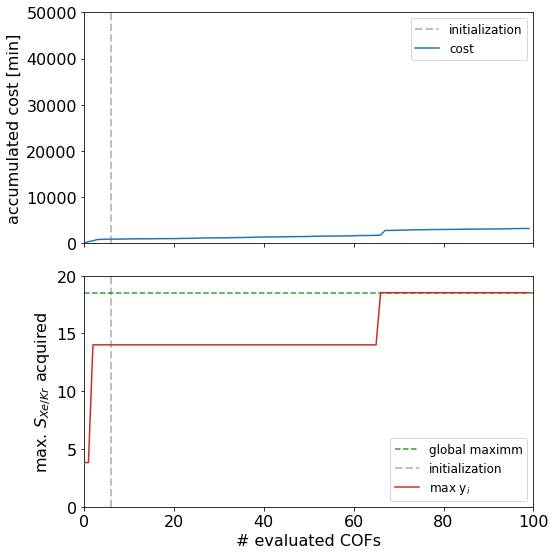

In [16]:
plt.figure(figsize=(8, 8))

ax1 = plt.subplot(2, 1, 1)
plt.axvline(x=hl, label="initialization", color="k", alpha=0.25, linestyle="--", lw=2)
plt.plot(range(len(ids_acquired)), net_cost, label="cost", color="tab:blue")
plt.legend(fontsize=12)
plt.ylabel("accumulated cost [min]")
plt.xlim(xmin=0, xmax=nb_iterations)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylim(ymin=0, ymax=50000)

plt.subplot(2, 1, 2, sharex=ax1)
plt.axhline(y=max(y[1]), label="global maximm", color="tab:green", ls="--", lw=1.5)
plt.axvline(x=hl, label="initialization", color="k", alpha=0.25, linestyle="--", lw=2)
plt.plot(range(len(ids_acquired)), max_selectivity, label="max y$_i$", color="tab:red", zorder=3)
plt.ylim(ymin=0, ymax=20)
plt.xlabel("# evaluated COFs")
plt.ylabel("max. $S_{Xe/Kr}$ acquired")

plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig("figs/mfbo/multi_fidelity_bo_search_efficientcy_curve.pdf", dpi=600, format="pdf")
plt.savefig("figs/mfbo/multi_fidelity_bo_search_efficientcy_curve.png", dpi=600, format="png")
plt.show()

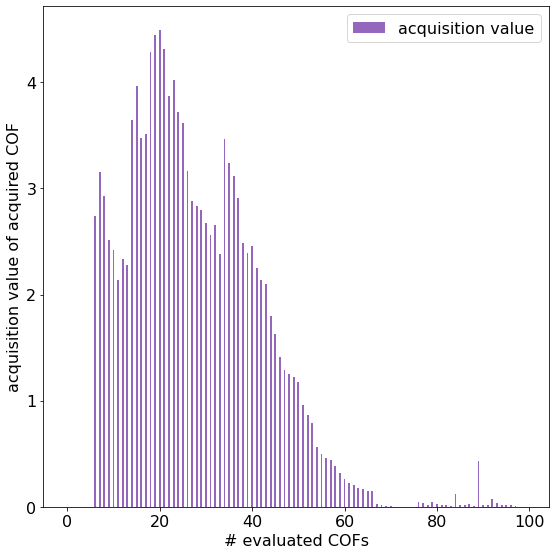

In [19]:
plt.figure(figsize=(8, 8))

plt.bar(range(len(ids_acquired)), stored_acquisition_values.detach().numpy(), 0.4, 
        label="acquisition value", color="tab:purple")

plt.xlabel("# evaluated COFs")
plt.ylabel("acquisition value of acquired COF")
plt.legend(fontsize=16)

plt.tight_layout()
# plt.savefig("figs/mfbo/multi_fidelity_bo_acquisition_values.pdf", dpi=600, format="pdf")
plt.show()